# Project 2

Ali Harb

In [345]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite as bi
import operator 
from operator import itemgetter
import numpy as np
import community
import itertools
from multiprocessing import Pool
import matplotlib.colors as mcolors
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
import wordcloud
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from subprocess import check_output
import csv

+ Identify a large 2-node network dataset—you can start with a dataset in a repository.
+ Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
+ What can you infer about each of the distinct groups?

In [279]:
sql_con = pymysql.connect(host='104.196.212.179', port=3306, 
                          user='root', passwd='data620pw',
                          db='reddit')

In [280]:
reddit = pd.read_sql('SELECT DISTINCT author, responder, COUNT(1) as weight FROM comments '
                     'GROUP BY author, responder '
                     'HAVING author<>"[deleted]" AND responder<>"[deleted]";', con=sql_con)

reddit_comment = pd.read_sql('SELECT * from comments;', con=sql_con)


In [281]:
users = pd.read_sql('SELECT username, betweenness, degree FROM users', con=sql_con)
 
sql_con.close()


In [282]:
reddit.loc[0:2]

,author,responder,weight
0,---DevilsAdvocate---,dannybtw,1
1,---DevilsAdvocate---,ThisFreaknGuy,2
2,-Covariance,DomeSlave,1


In [283]:
G = nx.Graph()

# Add nodes
nodes = set(reddit.loc[:, "author"])
authorNodes=nodes
nodes.union(set(reddit.loc[:, "responder"]))
nodes = list(nodes)
G.add_nodes_from(nodes)
edges=[tuple(x) for x in reddit.loc[:, "author":"responder"].values]
G.add_weighted_edges_from([tuple(x) for x in reddit.values])

In [284]:
def trim_edges(g, weight = 1):
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,weight=edata['weight']) 
    return g2

In [285]:
def island_method(g, iterations = 5):
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [286]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 10233
Number of edges: 15756
Average degree:   3.0794


In [287]:
print(nx.is_connected(G))

False


In [288]:
len(list(nx.connected_component_subgraphs(G)))

129

In [289]:
print([len(c) for c in nx.connected_component_subgraphs(G)
if len(c) > 2])

[9928, 3, 9, 5, 3, 3, 3, 5, 5, 5, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 4, 5, 3, 3, 3, 3, 4, 3, 3, 3]


In [292]:
islands=island_method(G,11)

In [293]:
islands

[[1, <networkx.classes.graph.Graph at 0xee00e80>],
 [2, <networkx.classes.graph.Graph at 0xee00780>],
 [3, <networkx.classes.graph.Graph at 0xee00fd0>],
 [4, <networkx.classes.graph.Graph at 0xee00240>],
 [5, <networkx.classes.graph.Graph at 0xee00550>],
 [6, <networkx.classes.graph.Graph at 0xee009e8>],
 [7, <networkx.classes.graph.Graph at 0xee00c18>],
 [8, <networkx.classes.graph.Graph at 0xee00f60>],
 [9, <networkx.classes.graph.Graph at 0xee00e10>],
 [10, <networkx.classes.graph.Graph at 0xee00a90>],
 [11, <networkx.classes.graph.Graph at 0xee006d8>],
 [12, <networkx.classes.graph.Graph at 0xee00320>],
 [13, <networkx.classes.graph.Graph at 0xee00518>],
 [14, <networkx.classes.graph.Graph at 0xee005c0>],
 [15, <networkx.classes.graph.Graph at 0xee000f0>],
 [16, <networkx.classes.graph.Graph at 0xee00080>],
 [17, <networkx.classes.graph.Graph at 0xee00630>],
 [18, <networkx.classes.graph.Graph at 0xee00048>],
 [19, <networkx.classes.graph.Graph at 0xf9bb320>],
 [20, <networkx.class

Applying the island method

In [295]:
for i in islands:
    print(i[0],len(i[1]),len(list(nx.connected_component_subgraphs(i[1]))))

1 1315 302
2 492 164
3 256 98
4 130 52
5 73 34
6 46 21
7 36 17
8 21 10
9 13 6
10 11 5
11 11 5
12 11 5
13 8 4
14 6 3
15 5 3
16 5 3
17 3 2
18 3 2
19 3 2
20 2 1


In [272]:
len(list(nx.connected_component_subgraphs(islands[19][1])))

1

In [173]:
pos=nx.spring_layout(islands[19][1])

(-0.6850467214133726,
 0.6850467214133725,
 -1.107154318058363,
 1.1071543180583625)

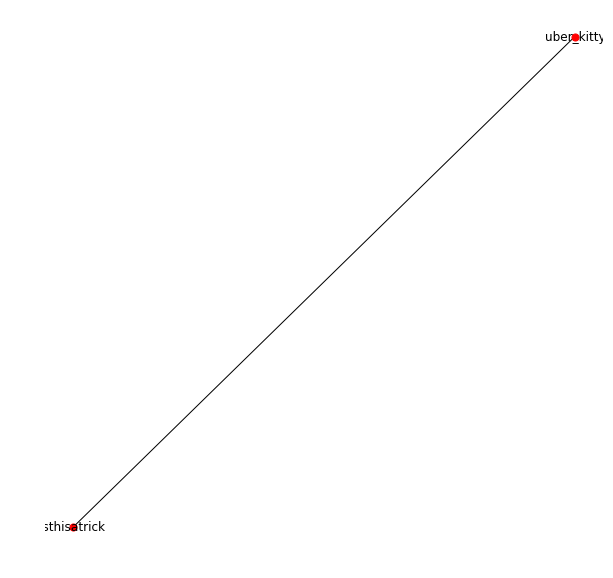

In [273]:
fig = plt.gcf()
fig.set_size_inches(10,10)
nx.draw_networkx(islands[19][1],pos,node_size=50,label=False)
plt.axis('off')

The reddit and reviewer network has over 10233 nodes, but the network is split into 129 component subgraphs. The largest component is 9928. 
After applying the island methods there are it divides the graph into 20 islands. Every one of these island has its own small cliques except for the last one.

In [325]:
M = bi.projected_graph(G, authorsnx)

In [326]:
len(list(nx.connected_component_subgraphs(M)))

189

In [327]:
[len(c) for c in nx.connected_component_subgraphs(M)
if len(c) > 5]

[9928]

In [328]:
authorsnx=bi.weighted_projected_graph(G, M, ratio=False)

In [329]:
len(authorsnx.nodes())

10168

In [330]:
len(list(nx.connected_component_subgraphs(authorsnx)))

189

In [331]:
len([len(c) for c in nx.connected_component_subgraphs(authorsnx)
if len(c) < 2])

155

In [332]:
print([len(c) for c in nx.connected_component_subgraphs(authorsnx)
if len(c) > 1])

[9928, 2, 5, 4, 2, 2, 2, 4, 5, 4, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2]


In [333]:
islands=island_method(authorsnx,11)

In [334]:
for i in islands:
    print(i[0],len(i[1]),len(list(nx.connected_component_subgraphs(i[1]))))

1 2184 94
2 451 24
3 164 17
4 80 13
5 48 10
6 34 8
7 14 6
8 7 3
9 2 1
10 2 1
11 2 1


In [335]:
t=nx.DiGraph(islands[2][1])

In [336]:
census=nx.triadic_census(t)

In [337]:
census

{'003': 680305,
 '012': 0,
 '021C': 0,
 '021D': 0,
 '021U': 0,
 '030C': 0,
 '030T': 0,
 '102': 39647,
 '111D': 0,
 '111U': 0,
 '120C': 0,
 '120D': 0,
 '120U': 0,
 '201': 1667,
 '210': 0,
 '300': 145}

In [338]:
cliques = list(nx.find_cliques(islands[2][1]))

In [343]:
cliques[0:10]

[['SerBearistanSelmy', 'rgonzal'],
 ['lameskiana', '0xD153A53'],
 ['Deggyy', 'Geosaurusrex'],
 ['shinyfuntimes', 'hawkish25'],
 ['Portalman4', 'JohnMiltonJamesJoyce'],
 ['Portalman4', 'USOutpost31'],
 ['Howie_The_Lord', 'BillMaher4President'],
 ['barassmonkey17', 'redditminus'],
 ['barassmonkey17', 'Veeron'],
 ['barassmonkey17', 'MrConfucius']]

In [342]:
nx.transitivity(t)

0.20694576593720265